# Multiple Rectangles or Triangles

## Import Packages

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
%matplotlib inline

## Data Generation

In [20]:
num_imgs = 50000

img_size = 16
min_rect_size = 4
max_rect_size = 7
num_objects = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size = 2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x + width, y:y + height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size = 2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
            
imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 3, 4))

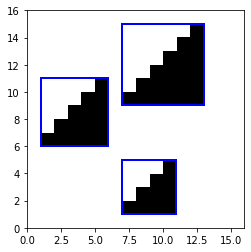

In [21]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'r' if shape[0] == 0 else 'b', fc = 'none'))

## Preprocessing

In [22]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 256), -4.8849813083506885e-18, 0.9999999999999992)

In [23]:
y = np.concatenate([bboxes / img_size, shapes], axis = -1).reshape(num_imgs, -1)
y.shape

(50000, 15)

## Train Test Split

In [24]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Model

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.5), 
        Dense(y.shape[-1])
    ])
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                3855      
Total params: 69,647
Trainable params: 69,647
Non-trainable params: 0
_________________________________________________________________


## IoU Calculating Function

In [26]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating Function

In [27]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [30]:
from itertools import permutations
num_epochs = 50
iou_max = 0.
fact = math.factorial(num_objects)

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epochs = np.zeros((len(flipped_train_y), num_epochs))
dists_epochs = np.zeros((len(flipped_train_y), num_epochs))
mses_epochs = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch ', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1)
    pred_y = model.predict(train_X)
    
    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        pred = pred_bboxes.reshape(num_objects, -1)
        exp = exp_bboxes.reshape(num_objects, -1)
        p_exp = list(permutations(exp))
        
        # ignore the shape value
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        p_exp_bboxes = list(permutations(exp_bboxes))
        ious = np.zeros((fact, num_objects))
        dists = np.zeros((fact, num_objects))
        mses = np.zeros((fact, num_objects))
        p_ious = np.zeros(fact)
        p_mses = np.zeros(fact)
        p_dists = np.zeros(fact)
        
        for j, exp_bboxes in enumerate(p_exp_bboxes):
            exp_bboxes = list(exp_bboxes) 
            for k in range(num_objects):
                ious[j, k] = IOU(exp_bboxes[k], pred_bboxes[k])
                dists[j, k] = distance(exp_bboxes[k], pred_bboxes[k])
                mses[j, k] = np.mean(np.square(exp_bboxes[k] - pred_bboxes[k]))
            p_ious[j] = sum(ious[j, :])
            p_dists[j] = sum(dists[j, :])
            p_mses[j] = sum(mses[j, :])
            
        keymax = p_mses.argmin()
        ious_epochs[i, epoch] += p_ious[keymax] / num_objects
        dists_epochs[i, epoch] += p_dists[keymax] / num_objects
        mses_epochs[i, epoch] += p_mses[keymax] / num_objects
        
        flipped_train_y[i] = np.array(p_exp[keymax]).flatten()
        if keymax != 0:
            flipped[i, epoch] = 1.
        
        if p_ious[keymax] > iou_max:
            model.save('Multiple_Rectangles_or_Triangles_model.h5')
            iou_max = p_ious[keymax]
    
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epochs[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epochs[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epochs[:, epoch])))

Epoch  0
1250/1250 [==============================] - 1s 901us/step - loss: 0.0573 - val_loss: 0.0541
Flipped 82.49499999999999 % of all elements
Mean IOU: 0.2030865115243235
Mean dist: 0.2158248886061032
Mean mse: 0.014976224766963551
Epoch  1
1250/1250 [==============================] - 1s 992us/step - loss: 0.0544 - val_loss: 0.0548
Flipped 45.7725 % of all elements
Mean IOU: 0.25282042079709166
Mean dist: 0.18828829052607124
Mean mse: 0.012015093278984222
Epoch  2
1250/1250 [==============================] - 1s 905us/step - loss: 0.0514 - val_loss: 0.0569
Flipped 31.0525 % of all elements
Mean IOU: 0.29698333949631595
Mean dist: 0.16786727943309138
Mean mse: 0.010075658757685008
Epoch  3
1250/1250 [==============================] - 1s 922us/step - loss: 0.0483 - val_loss: 0.0585
Flipped 25.685000000000002 % of all elements
Mean IOU: 0.33530935325395705
Mean dist: 0.15081169795500105
Mean mse: 0.008552717987837539
Epoch  4
1250/1250 [==============================] - 1s 935us/step -

1250/1250 [==============================] - 1s 913us/step - loss: 0.0338 - val_loss: 0.0660
Flipped 7.305000000000001 % of all elements
Mean IOU: 0.440984121559301
Mean dist: 0.11079593896837996
Mean mse: 0.005501127870731501
Epoch  37
1250/1250 [==============================] - 1s 1ms/step - loss: 0.0339 - val_loss: 0.0655
Flipped 7.085 % of all elements
Mean IOU: 0.43824347178567313
Mean dist: 0.11348590213712736
Mean mse: 0.005644086069519003
Epoch  38
1250/1250 [==============================] - 1s 936us/step - loss: 0.0337 - val_loss: 0.0659
Flipped 6.775 % of all elements
Mean IOU: 0.4478047444492153
Mean dist: 0.11158379877285131
Mean mse: 0.005580184248357176
Epoch  39
1250/1250 [==============================] - 1s 912us/step - loss: 0.0337 - val_loss: 0.0656
Flipped 7.005 % of all elements
Mean IOU: 0.4382887777899613
Mean dist: 0.11316574048220585
Mean mse: 0.005629178013777667
Epoch  40
1250/1250 [==============================] - 1s 901us/step - loss: 0.0336 - val_loss: 

## Flipping Track

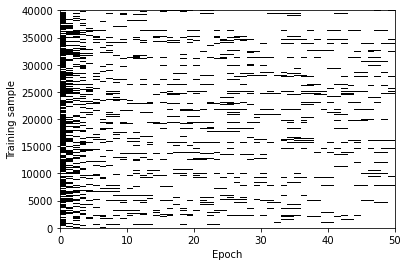

In [31]:
# Show flippings for a few training samples.
plt.pcolormesh(flipped[:, :], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('multiple-rectangles_or_triangles_flips.png', dpi = 100)
plt.show()

## Metrics Track

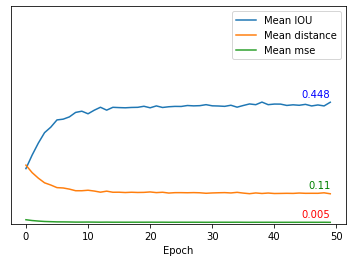

In [32]:
# Plot metrics on the training data.
mean_ious_epoch = np.mean(ious_epochs, axis = 0)
mean_dists_epoch = np.mean(dists_epochs, axis = 0)
mean_mses_epoch = np.mean(mses_epochs, axis = 0)
plt.plot(mean_ious_epoch, label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label = 'Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label = 'Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')

plt.xlabel('Epoch')
# Hide y tick
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.legend()
plt.ylim(0, 0.8)
plt.savefig('training_metrics.png', dpi = 100)

## Denormalize Data

In [33]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000, 3, 4), (10000, 3, 1))

## Visualize Results

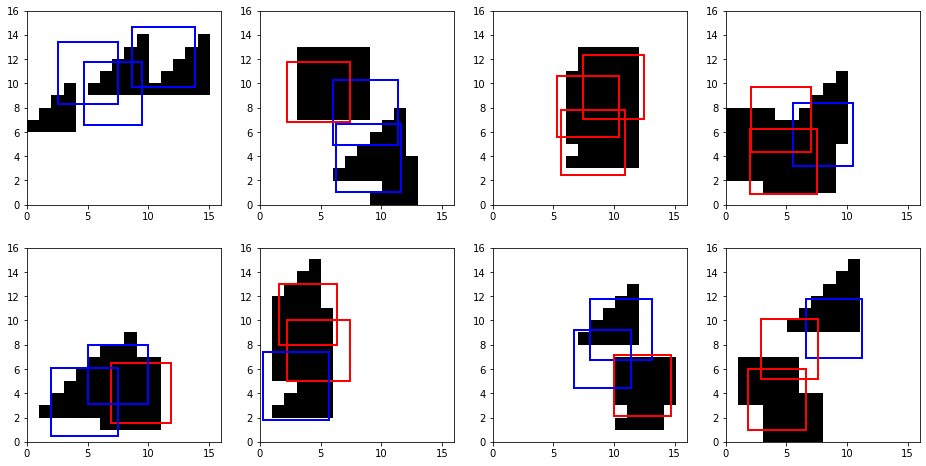

In [34]:
plt.figure(figsize = (16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r' if pred_shape[0] <= 0.5 else 'b', fc = 'none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

## Overall Assessment

In [36]:
from keras.models import load_model
from itertools import permutations
fact = math.factorial(num_objects)
model_test = load_model('Multiple_Rectangles_or_Triangles_model.h5')
pred_y = model_test.predict(test_X)
sum_iou = 0.
sum_dist = 0.
sum_mse = 0.
test_y = np.array(test_y)

for pred_bboxes, test_bboxes in zip(pred_y, test_y):
    
    pred_bboxes = pred_bboxes.reshape(num_objects, -1)
    test_bboxes = test_bboxes.reshape(num_objects, -1)
    
    p_test_bboxes = list(permutations(test_bboxes))
    p_ious = np.zeros(fact)
    p_dists = np.zeros(fact)
    p_mses = np.zeros(fact)
    ious = np.zeros((fact, num_objects))
    dists = np.zeros((fact, num_objects))
    mses = np.zeros((fact, num_objects))
    
    for j, test_bboxes in enumerate(p_test_bboxes):
        test_bboxes = list(test_bboxes) 
        for k in range(num_objects):
            ious[j, k] = IOU(test_bboxes[k], pred_bboxes[k])
            dists[j, k] = distance(test_bboxes[k], pred_bboxes[k])
            mses[j, k] = np.mean(np.square(test_bboxes[k] - pred_bboxes[k]))
        p_ious[j] = sum(ious[j, :])
        p_dists[j] = sum(dists[j, :])
        p_mses[j] = sum(mses[j, :])
            
    keymax = p_ious.argmax()
    sum_iou += p_ious[keymax] 
    sum_dist += p_dists[keymax] 
    sum_mse += p_mses[keymax] 

mean_iou = sum_iou / (num_objects * len(pred_y))
mean_dist = sum_dist / (num_objects * len(pred_y))
mean_mse = sum_mse / (num_objects * len(pred_y))
print('IoU:', mean_iou)
print('Distance:', mean_dist)
print('MSE:', mean_mse)

IoU: 0.44049974894277083
Distance: 0.11516086963991934
MSE: 0.02735857395528621
